In [ ]:
# MEMO
'''
評価関数がpercent MAEということは、priceが高い群の予想を大きく外さないことが重要
yearにおかしなやつ(>2023)がある
高価な車はodometerが多く、diesel車が多い傾向

仮説

'''

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing as preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgbm
from sklearn.metrics import mean_absolute_percentage_error
import jaconv
import seaborn as sns

In [31]:
# import data
train_df = pd.read_csv('data/train.csv')

def convert(df, column):
    df[column] = df[column].str.lower()
    values = df[column].values.tolist()
    new_values = [jaconv.z2h(x, kana=False, ascii=True, digit=False) for x in values]
    df[column] = new_values
    return df

train_df = convert(train_df, 'manufacturer')
train_df['year_str'] = train_df['year'].astype(str)

def clean_data(orig_df):
    # Create a copy
    df_cleaned = orig_df.copy()

    # Use NaN for unrealistic year values
    df_cleaned.loc[df_cleaned['year'] > 2023, 'year'] = pd.NA
    df_cleaned['year_str'] = df_cleaned['year'].astype(str)

    # Handle negative and unrealistic odometer values
    df_cleaned.loc[(df_cleaned['odometer'] < 0), 'odometer'] = -99999
    df_cleaned.loc[(df_cleaned['odometer'] > 1e6), 'odometer'] = pd.NA

    # Make manufacturer lowercase and hankaku
    df_cleaned = convert(df_cleaned, 'manufacturer')

    # feature creation
    df_cleaned['condition_paint_color'] = df_cleaned['condition'] + '_' + df_cleaned['paint_color']
    df_cleaned['condition_fuel'] = df_cleaned['condition'] + '_' + df_cleaned['fuel']
    df_cleaned['condition_manufacturer'] = df_cleaned['condition'] + '_' + df_cleaned['manufacturer']
    df_cleaned['condition_year_str'] = df_cleaned['condition'] + '_' + df_cleaned['year_str']
    df_cleaned['condition_drive_fue;'] = df_cleaned['condition'] + '_' + df_cleaned['drive'] + '_' + df_cleaned['fuel']
    
    return df_cleaned

train_df = clean_data(train_df)


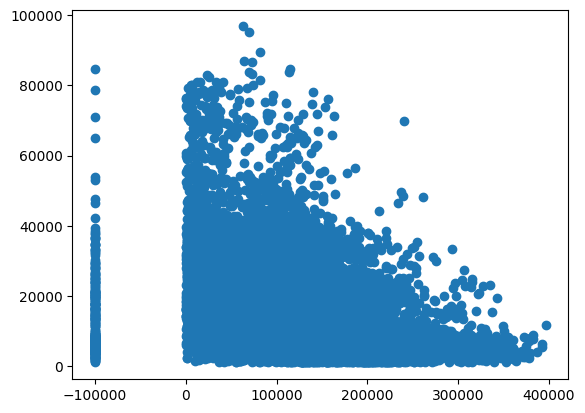

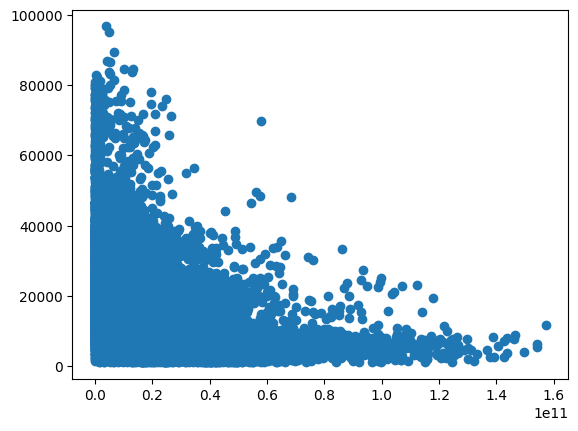

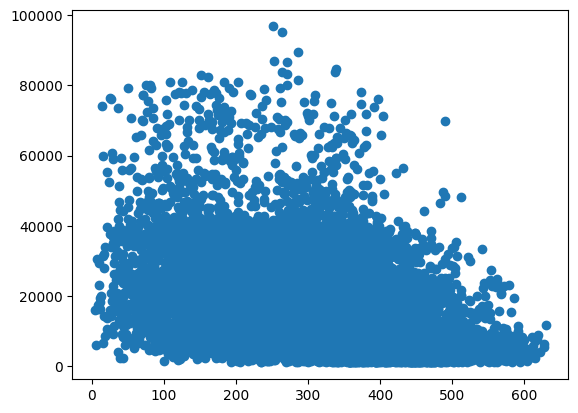

In [111]:
odometer_squared = train_df['odometer']**2
train_df['odometer_squared'] = odometer_squared
odometer_root = train_df['odometer']**(1/2)
train_df['odometer_root'] = odometer_root
plt.scatter(train_df['odometer'], train_df['price'])
plt.show()
plt.scatter(train_df['odometer_squared'], train_df['price'])
plt.show()
plt.scatter(train_df['odometer_root'], train_df['price'])
plt.show()

In [60]:
cat_cols = train_df.select_dtypes(include=['object']).columns
for cat_col in cat_cols:
    '''
    plt.bar(train_df.groupby(cat_col)["price"].mean().index, train_df.groupby(cat_col)["price"].mean().values)
    plt.title(cat_col)
    plt.xlabel("category")
    plt.ylabel("price")
    plt.show()
    '''

In [47]:
# import data
test_df = pd.read_csv('data/test.csv')

def convert(df, column):
    df[column] = df[column].str.lower()
    values = df[column].values.tolist()
    new_values = [jaconv.z2h(x, kana=False, ascii=True, digit=False) for x in values]
    df[column] = new_values
    return df

test_df = convert(test_df, 'manufacturer')
test_df['year_str'] = test_df['year'].astype(str)

cat_cols = test_df.select_dtypes(include=['object']).columns
for cat_col in cat_cols:
    plt.bar(test_df.groupby(cat_col)["price"].mean().index, test_df.groupby(cat_col)["price"].mean().values)
    plt.title(cat_col)
    plt.xlabel("category")
    plt.ylabel("price")
    plt.show()

KeyError: 'Column not found: price'

In [ ]:
# Label Encoding
le = preprocessing.LabelEncoder()
categorical_column = ['region', 'manufacturer', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'state']
for col in categorical_column:
    train_df[col] = le.fit_transform(train_df[col].astype(str))

In [34]:
# regionからstateを決定する

# region -> stateが一意に定まることを確認
region_state = {region:{} for region in train_df['region'].unique()}
for row, value in train_df.iterrows():
    if not pd.isna(value['state']):
        if value['state'] not in region_state[value['region']]:
            region_state[value['region']][value['state']] = 1
        else:
            region_state[value['region']][value['state']] += 1

for region, state_dict in region_state.items():
    if len(state_dict) > 1 or state_dict == {}:
        region_state[region] = pd.NA
    else:
        region_state[region] = list(state_dict.keys())[0]

# regionからstateを決定
train_df_new = train_df.copy()
train_df_new['state'] = [region_state[region] if pd.isna(state) else state for region, state in zip(train_df['region'], train_df['state'])]
train_df_new.to_csv('state_fixed_train.csv', index=False)

# 一部、データ不足のため決定できないStateがあることを確認
print(train_df_new.info())

northwest KS {}
ashtabula {}
southern WV {}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27532 entries, 0 to 27531
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      27532 non-null  int64  
 1   region                  27532 non-null  object 
 2   year                    27528 non-null  float64
 3   manufacturer            27532 non-null  object 
 4   condition               27532 non-null  object 
 5   cylinders               27532 non-null  object 
 6   fuel                    26293 non-null  object 
 7   odometer                27526 non-null  float64
 8   title_status            27076 non-null  object 
 9   transmission            27532 non-null  object 
 10  drive                   27532 non-null  object 
 11  size                    27532 non-null  object 
 12  type                    27076 non-null  object 
 13  paint_color             27532 non-null  object 

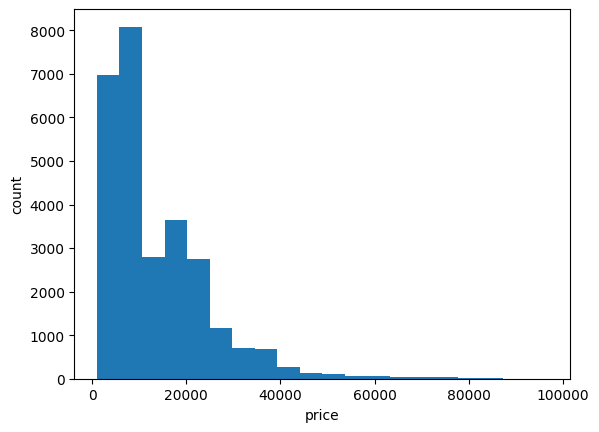

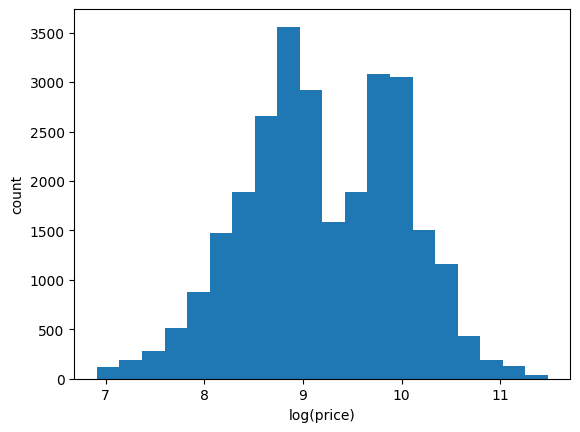

skewness:  -0.0904631588607781


In [104]:
price_high = train_df[train_df["price"] > 24000]
plt.hist(train_df["price"], bins=20)
plt.xlabel("price")
plt.ylabel("count")
plt.show()

price_log = np.log(train_df["price"])
plt.hist(price_log, bins=20)
plt.xlabel("log(price)")
plt.ylabel("count")
plt.show()
print('skewness: ', price_log.skew())

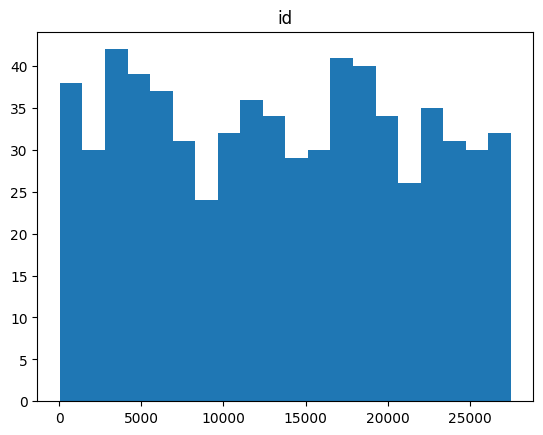

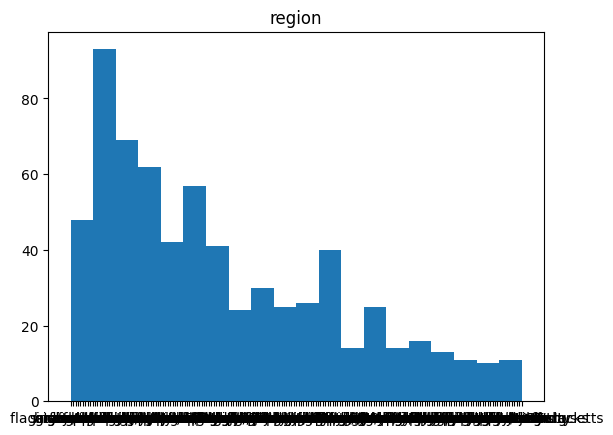

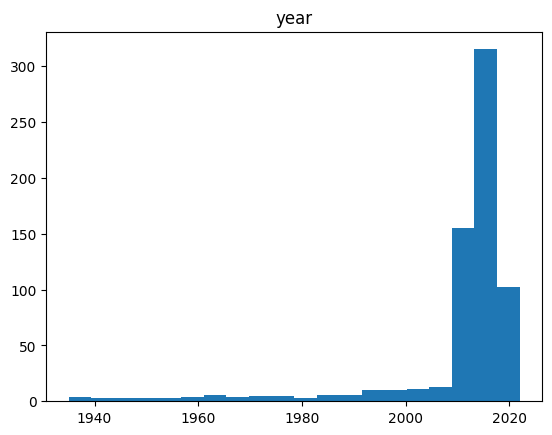

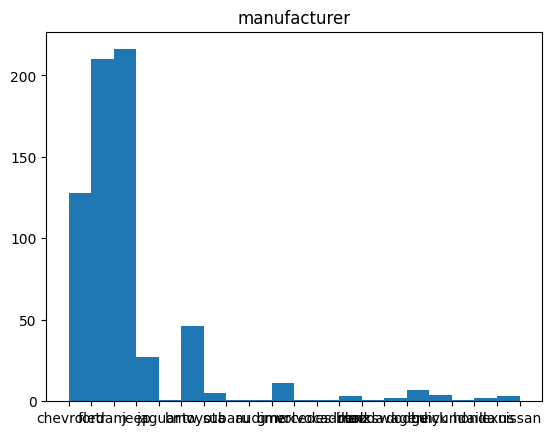

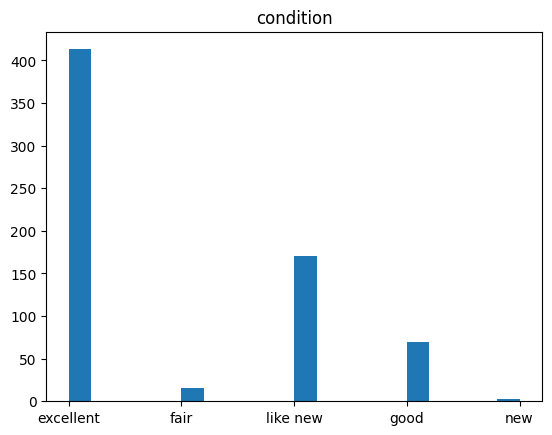

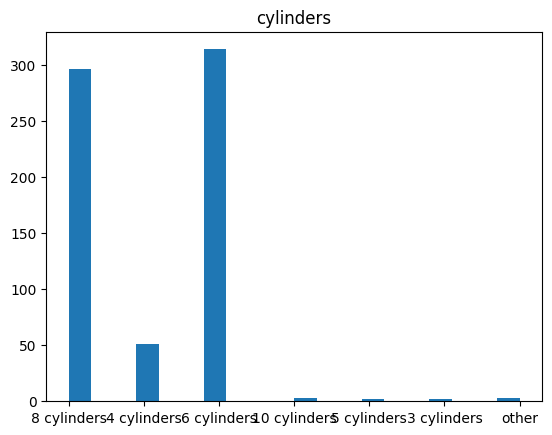

TypeError: 'value' must be an instance of str or bytes, not a float

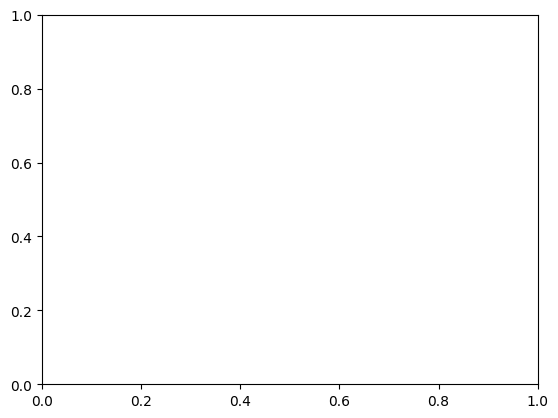

In [112]:
train_df_higher = train_df[train_df['price'] >= 40000]
for col, data in train_df_higher.items():
    plt.hist(data, bins=20)
    plt.title(col)
    plt.show()

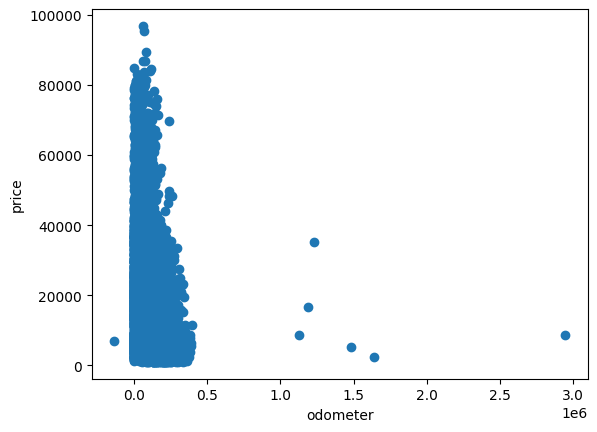

In [106]:
odometer_ = train_df['odometer'].values
#odometer_ = [x if (x >= 0 and x < 1e6) else np.mean(odometer_) for x in odometer_]
plt.scatter(odometer_, train_df['price'])
plt.xlabel('odometer')
plt.ylabel('price')
plt.show()


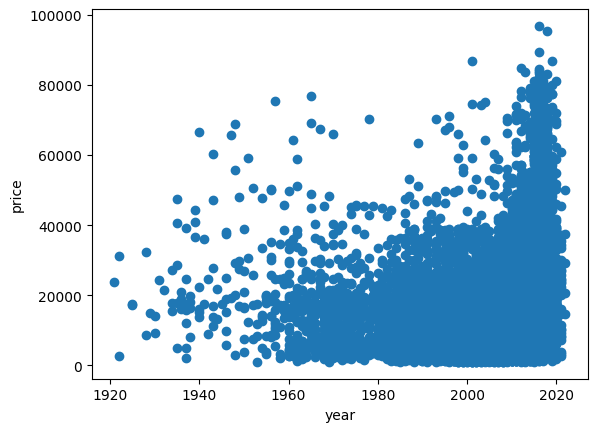

In [20]:
year_ = train_df['year']
year_ = [x if x <= 2023 else np.mean(year_) for x in year_]
plt.scatter(year_, train_df['price'])
plt.xlabel('year')
plt.ylabel('price')
plt.show()
